In [1]:
import pandas as pd
import pickle as pkl
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from utils import generate_homogeneous_graph
from sentence_transformers import SentenceTransformer
import pickle as pkl

m = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
df = pd.read_csv('results/Headlines_gemma2:27b.csv') 
df = df.dropna().reset_index(drop=True)
g_first  = generate_homogeneous_graph(df, m, llm_class=False)

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['causal', 'non_causal'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

df_egae = pd.DataFrame()

df_egae['y'] = [g_first.nodes[node]['label'] for node in g_first.nodes()]
df_egae['node'] = [node for node in g_first.nodes()]

nodes_aux = df_egae[df_egae['y'] == 'aux']['node'].to_list()

df = df_egae[df_egae['y'] != 'aux'].reset_index(drop=True)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_trues, y_preds = [], []

graphs_kfold = []
for train_index, test_index in kf.split(df['node'], df['y']):

    g_aux = g_first.copy()

    nodes_train = df[(df.index.isin(train_index)) & (df['y'] == 'causal')]['node'].to_list()

    nodes_out = df[(df.index.isin(train_index)) & (df['y'] != 'causal')]['node'].to_list()
    
    nodes_test = df[df.index.isin(test_index)]['node'].to_list()
    
    for node in nodes_train:
        g_aux.nodes[node]['train'] = 1
        g_aux.nodes[node]['test'] = 0
        g_aux.nodes[node]['aux'] = 0

    for node in nodes_test:
        g_aux.nodes[node]['train'] = 0
        g_aux.nodes[node]['test'] = 1
        g_aux.nodes[node]['aux'] = 0

    for node in nodes_out:
        g_aux.nodes[node]['train'] = 0
        g_aux.nodes[node]['test'] = 0
        g_aux.nodes[node]['aux'] = 1

    for node in nodes_aux:
        g_aux.nodes[node]['train'] = 0
        g_aux.nodes[node]['test'] = 0
        g_aux.nodes[node]['aux'] = 1
   
    graphs_kfold.append(g_aux)

In [2]:
import torch
from torch_geometric.nn import GATv2Conv
import torch.nn as nn
import random

class Encoder(torch.nn.Module):
    def __init__(self, input_len, dim, heads):
        super(Encoder, self).__init__()

        seed = 42
        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)
        torch.cuda.manual_seed_all(seed)

        self.encoder_layer_1 = GATv2Conv(input_len, 256, heads=heads, concat=False)
        self.encoder_layer_2 = GATv2Conv(256, dim, heads=heads, concat=False)

    def forward(self, x, edge_index):
        rep_node_l1 = nn.LeakyReLU(0.2)(self.encoder_layer_1(x=x, edge_index=edge_index)) 
        rep_node_l2 = nn.Tanh()(self.encoder_layer_2(x=rep_node_l1, edge_index=edge_index))

        return rep_node_l2

def one_class_loss(center, radius, learned_representations, mask):

    scores = anomaly_score(center, radius, learned_representations, mask)

    ocl_loss = torch.mean(torch.where(scores > 0, scores + 1, torch.exp(scores)))

    return ocl_loss

def anomaly_score(center, radius, learned_representations, mask):

    l_r_mask = torch.BoolTensor(mask)

    dist = torch.sum((learned_representations[l_r_mask] - center) ** 2, dim=1)

    scores = dist - radius ** 2

    return scores

def one_class_masking(G):

    train_mask = np.zeros(len(G.nodes), dtype='bool')
    unsup_mask = np.zeros(len(G.nodes), dtype='bool')

    normal_train_idx = []
    unsup_idx = []
    unsup = []
    
    count = 0
    for node in G.nodes():
        if G.nodes[node]['train'] == 1:
            normal_train_idx.append(count)
        else:
            unsup_idx.append(count)
            unsup.append(node)
        count += 1

    train_mask[normal_train_idx] = 1
    unsup_mask[unsup_idx] = 1

    return train_mask, unsup_mask, unsup

def One_Class_GNN_prediction(center, radius, node_to_index, learned_representations, G, dic=False):

    with torch.no_grad():
        for node in G.nodes:
            G.nodes[node]['embedding_colgat'] = learned_representations[node_to_index[node]]

        interest = []
        outlier = []
        for node in G.nodes:
            if G.nodes[node]['test'] == 1 and G.nodes[node]['label'] == 'causal':
                interest.append(G.nodes[node]['embedding_colgat'].cpu().numpy())
            elif G.nodes[node]['test'] == 1 and G.nodes[node]['label'] == 'non_causal':
                outlier.append(G.nodes[node]['embedding_colgat'].cpu().numpy())

        dist_int = np.sum((interest - center.cpu().numpy()) ** 2, axis=1)

        scores_int = dist_int - radius.cpu().numpy() ** 2

        dist_out = np.sum((outlier - center.cpu().numpy()) ** 2, axis=1)

        scores_out = dist_out - radius.cpu().numpy() ** 2

        preds_interest = ['causal' if score < 0 else 'non_causal' for score in scores_int]
        preds_outliers = ['non_causal' if score > 0 else 'causal' for score in scores_out]

        y_true = ['causal'] * len(preds_interest) + ['non_causal'] * len(preds_outliers)
        y_pred = list(preds_interest) + list(preds_outliers)
        if dic:
            return classification_report(y_true, y_pred, output_dict=dic)
        else:
            return y_true, y_pred

/home/golo/.local/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/golo/.local/lib/python3.12/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/golo/.local/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/golo/.local/lib/python3.12/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/golo/.local/lib/python3.12/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/golo/.lo

In [4]:
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GAE
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
import matplotlib.pyplot as plt

index = 0
node_to_index = {}
for node in g_first.nodes():
    node_to_index[node] = index
    index+=1

def initialize_model(g, lr, ra, dim, heads):

    device = torch.device('cuda:0')

    graph_torch = from_networkx(g).to(device)

    model = GAE(Encoder(384, dim, heads))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = model.to(device)

    c = [0] * dim
    center = torch.Tensor(c)
    center = center.to(device)
    r = [ra]
    radius = torch.Tensor(r)
    radius = radius.to(device)

    mask, unsup_mask, unsup_nodes = one_class_masking(g)
    g_unsup = g.subgraph(unsup_nodes)
    graph_torch_unsup = from_networkx(g_unsup).to(device)

    return model, optimizer, graph_torch, unsup_mask, graph_torch_unsup, center, radius, mask

In [5]:
dim = 3
y_trues, y_preds = [], []
maior = 0
loss_rec = []
loss_ocl = []
embeddings = []
accuracies = []

for epochs in [700, 1000, 1500]:
    for ra in [0.35, 0.45, 0.5]:
        for mt in [100, 300, 500]:
            for heads in [1, 2, 3]:
                for lr in [0.0001, 0.001, 0.0005]:
                    for g in graphs_kfold:
                        model, optimizer, graph_torch, unsup_mask, graph_torch_unsup, center, radius, mask = initialize_model(g, lr, ra, dim, heads)
                        for epoch in range(epochs):
                            model.train()
                            optimizer.zero_grad()
                            
                            node_representation = model.encode(graph_torch.embedding.float(), graph_torch.edge_index)
                            
                            recon_loss = model.recon_loss(node_representation, graph_torch.edge_index)

                            recon_loss_unsup = model.recon_loss(node_representation[unsup_mask], graph_torch_unsup.edge_index)

                            ocl_loss = one_class_loss(center, radius, node_representation, mask)
                            
                            if epoch < mt:
                                loss = recon_loss
                            else:
                                loss = recon_loss_unsup + ocl_loss

                            loss.backward()
                            optimizer.step()

                        y_true, y_pred = One_Class_GNN_prediction(center, radius, node_to_index, node_representation, g, False)    
                        y_trues = np.concatenate([y_trues,y_true])
                        y_preds = np.concatenate([y_preds,y_pred])
                    f1_avg = round(classification_report(y_trues, y_preds, output_dict=True)['macro avg']['f1-score'], 3)
                    if f1_avg > maior:
                        maior = f1_avg
                        print(epochs, ra, mt, heads,lr)

700 0.35 100 1 0.0001


0.659 & 0.66 & 0.668 & 0.64 & 0.679 & 0.661


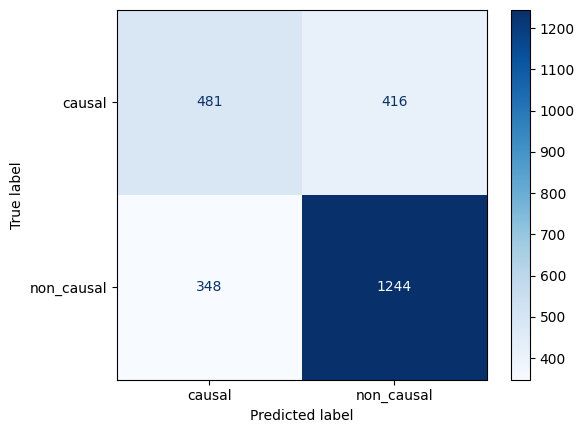

In [7]:
epochs, ra, mt, heads,lr = 700, 0.35, 100, 1, 0.0001

dim = 3

y_trues, y_preds = [], []
it = 0
loss_rec = []
loss_ocl = []
embeddings = []
accuracies = []

for g in graphs_kfold:
    model, optimizer, graph_torch, unsup_mask, graph_torch_unsup, center, radius, mask = initialize_model(g, lr, ra, dim, heads)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        node_representation = model.encode(graph_torch.embedding.float(), graph_torch.edge_index)
        
        recon_loss = model.recon_loss(node_representation, graph_torch.edge_index)

        recon_loss_unsup = model.recon_loss(node_representation[unsup_mask], graph_torch_unsup.edge_index)

        ocl_loss = one_class_loss(center, radius, node_representation, mask)
        
        if epoch < mt:
            loss = recon_loss
        else:
            loss = recon_loss_unsup + ocl_loss

        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and it == 1:
            ol = ocl_loss.detach().cpu().numpy()
            loss_ocl.append(ol)
            if epoch < mt:
                rl = recon_loss.detach().cpu().numpy()
            else:
                rl = recon_loss_unsup.detach().cpu().numpy()
            loss_rec.append(rl)
            embeddings.append(node_representation)
            f1 = One_Class_GNN_prediction(center, radius, node_to_index, node_representation, g, True)['macro avg']['f1-score']   
            accuracies.append(f1)

    y_true, y_pred = One_Class_GNN_prediction(center, radius, node_to_index, node_representation, g, False)
    f1_macro = classification_report(y_true, y_pred, output_dict=True)['macro avg']['f1-score']
    print(round(f1_macro, 3), end=" & ")
    y_trues = np.concatenate([y_trues,y_true])
    y_preds = np.concatenate([y_preds,y_pred])
    it+=1
print(round(classification_report(y_trues, y_preds, output_dict=True)['macro avg']['f1-score'], 3))
plot_confusion_matrix(y_trues, y_preds)

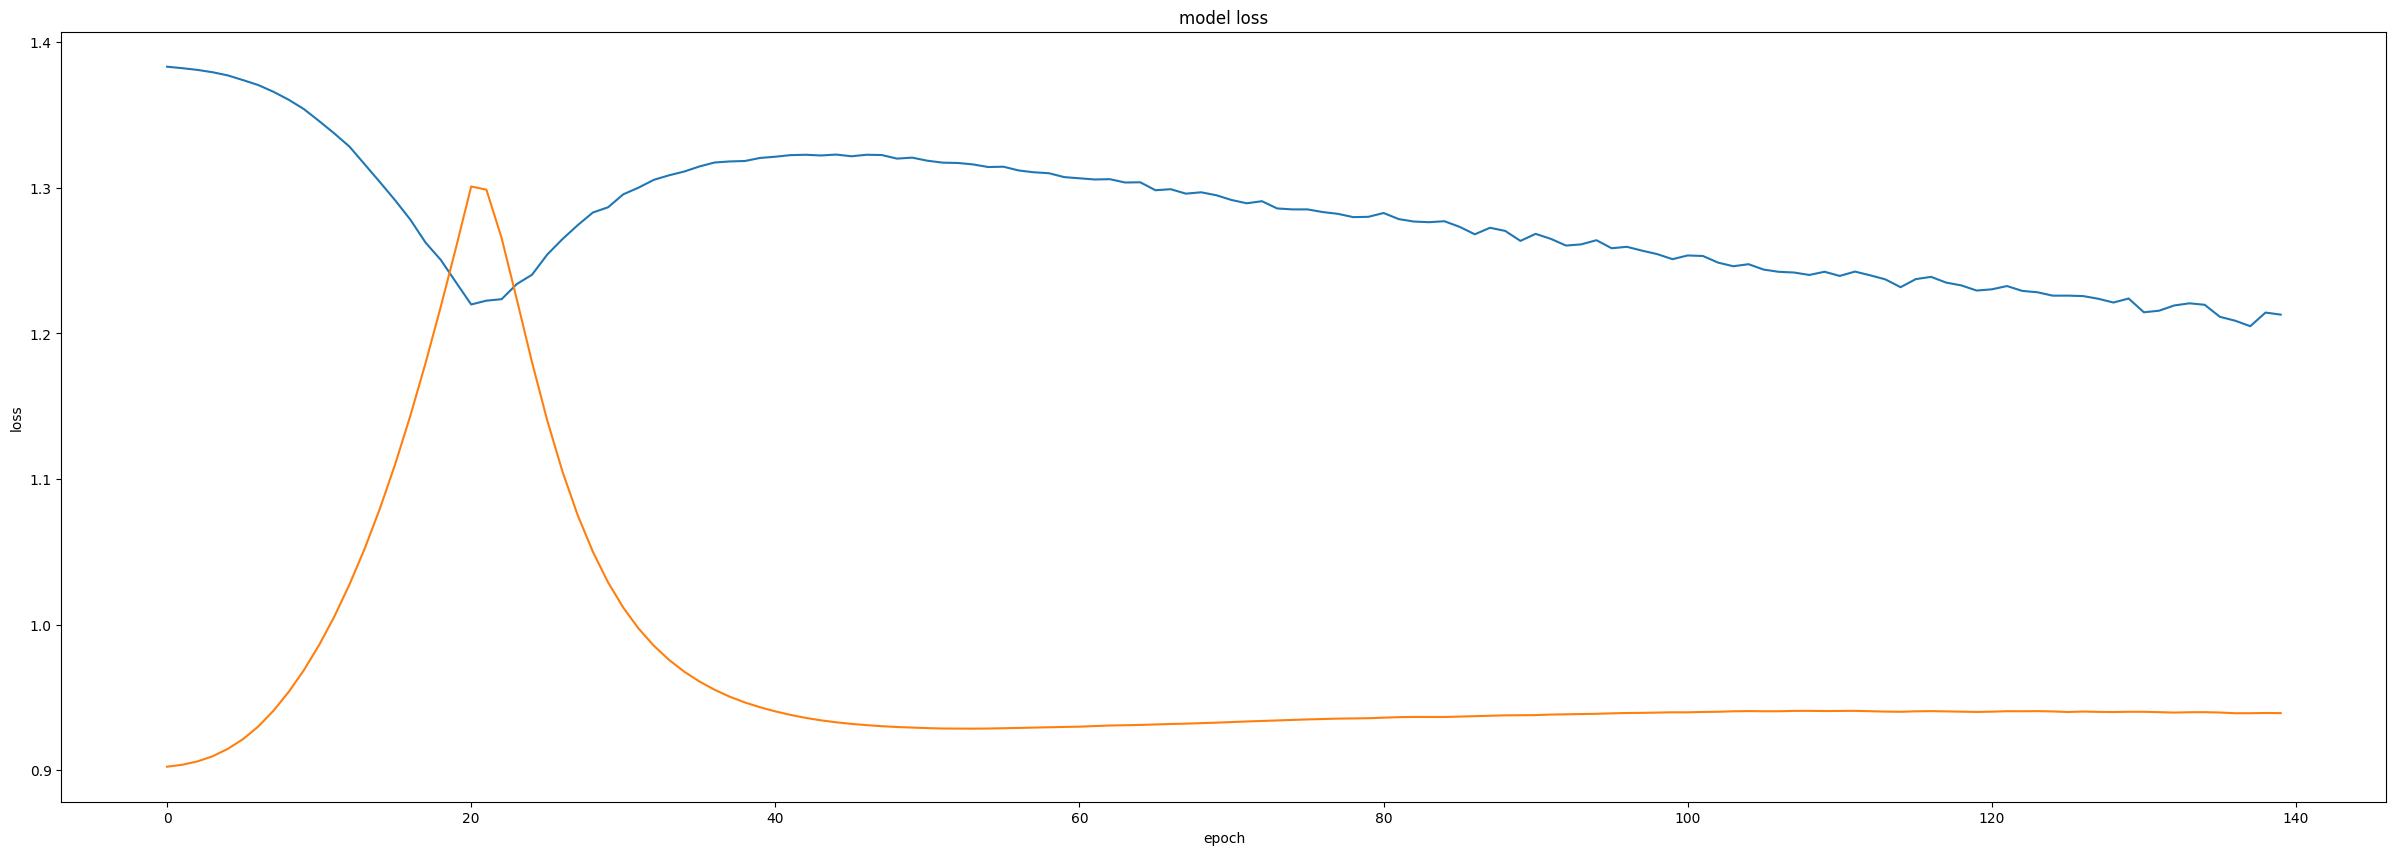

In [8]:
plt.figure(figsize=(30, 10))
plt.plot(loss_rec)
plt.plot(loss_ocl)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [9]:
x_max,y_max,z_max = 1, 1, 1

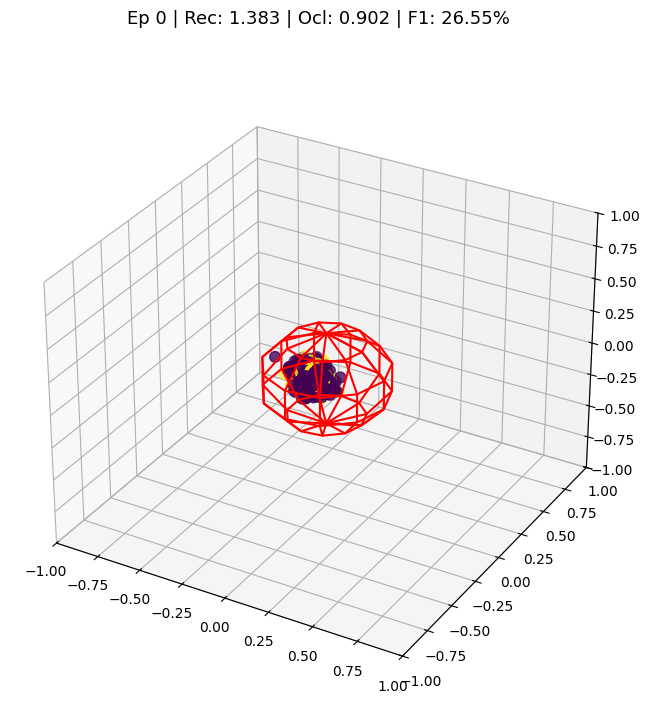

In [10]:
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display
from matplotlib import animation
import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.io as pio
pio.renderers.default = 'iframe'

labels = []
idxs = []
count=0

g = graphs_kfold[1]

for node in g.nodes():
    if g.nodes[node]['label'] == 'causal' and g.nodes[node]['train'] == 1:
        labels.append(0)
        idxs.append(count)
    elif g.nodes[node]['label'] == 'non_causal' and g.nodes[node]['test'] == 1:
        labels.append(1)
        idxs.append(count)
    elif g.nodes[node]['label'] == 'causal' and g.nodes[node]['test'] == 1:
        labels.append(0)
        idxs.append(count)
    count+=1
 
def animate(i):
    embed = embeddings[int(i/5)].detach().cpu().numpy()
    embed = np.array([embed[x] for x in idxs])
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2], s=60, c=labels)
    ax.scatter(0, 0, s=35, c='red')
    
    u, v = np.mgrid[0:2*np.pi:12j, 0:np.pi:6j]
    x = ra * np.cos(u)*np.sin(v)
    y = ra * np.sin(u)*np.sin(v)
    z = ra * np.cos(v)
    ax.plot_wireframe(x, y, z, color="r")
    ax.set_zlim(-z_max, z_max)
    
    plt.title(f'Ep {i} | Rec: {loss_rec[int(i/5)]:.3f} | Ocl: {loss_ocl[int(i/5)]:.3f} | F1: {accuracies[int(i/5)]*100:.2f}%', fontsize=13, pad=40)
    plt.xlim([-x_max, x_max])
    plt.ylim([-y_max, y_max])


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

anim = animation.FuncAnimation(fig, animate, np.arange(0, epochs, 5), interval=800, repeat=True)
html = HTML(anim.to_html5_video())

In [11]:
display(html)